# Modeling
Then we apply logistic regression and random forests. We choose logistic regression because feature dimension is high, and it would be relatively easy to separate linearly. We also use random forests for the feature analysis and comparison. 

# Summary
- We get around 9% increase in accuracy from the logistic regression model. 
- We get around 10% increase in accuracy with the random forest model. 
- We see that age has the highest importance.
- signup_method plays an important role while we didn't see it in the exploratory analysis. We need further analysis for this. 
- We see that activities like 'pending', 'requested' are an important feature for booking analysis. It could be a good starting point to analyze session data. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('train_user_session_merged.csv')

In [3]:
df.shape

(65136, 147)

# 1. Data Setup

## Preprocess

In [4]:
from sklearn.preprocessing import LabelEncoder

user_info = ['gender', 'ageCat']
target = 'country_destination'

actions = pd.read_csv('actions.csv', header=None, names=['action']).action.tolist()
action_summary = ['n_action']

for col in user_info:
    df[col] = LabelEncoder().fit_transform(df[col])

In [5]:
feature_columns = []
feature_columns += user_info
feature_columns += actions
feature_columns += action_summary

categorical_features=[i for i in range(len(user_info))]
numeric_features = [col for idx, col in enumerate(feature_columns) if idx not in categorical_features]

In [6]:
from sklearn.model_selection import train_test_split

X = df[feature_columns]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)

## Base Accuracy

In [7]:
y_cnt = df.country_destination.value_counts()
y_cnt_percent = y_cnt/y_cnt.sum()*100
y_cnt_percent

NDF    69.149165
US     30.850835
Name: country_destination, dtype: float64

# 2. Logistic Regression

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

X = df[feature_columns].copy()
y = df[target].copy()
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)

# standarize using train data
std = StandardScaler()
X_train[numeric_features] = std.fit_transform(X_train[numeric_features])
X_test[numeric_features] = std.transform(X_test[numeric_features])

# dummy variables for categorical variables
ohe = OneHotEncoder(categorical_features=categorical_features)
X_train_ohe = ohe.fit_transform(X_train).toarray()
X_test_ohe = ohe.transform(X_test).toarray()

In [10]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
clf.fit(X_train_ohe, y_train)
y_pred = clf.predict(X_test_ohe)

In [11]:
print('train accuracy: %.2f %%' %(clf.score(X_train_ohe, y_train)*100))
print('test accuracy: %.2f %%' %(clf.score(X_test_ohe, y_test)*100))

train accuracy: 78.31 %
test accuracy: 78.06 %


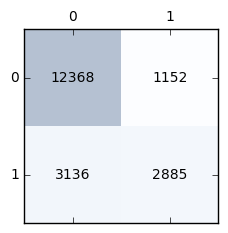

             precision    recall  f1-score   support

        NDF       0.80      0.91      0.85     13520
         US       0.71      0.48      0.57      6021

avg / total       0.77      0.78      0.77     19541



In [12]:
from sklearn.metrics import confusion_matrix, classification_report

mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(2.5,2.5))
ax.matshow(mat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(2):
    for j in range(2):
        ax.text(x=j,y=i,s=mat[i,j], ha='center', va='center')
plt.show()
print(classification_report(y_test, y_pred))

- The performance loss is primarily from failing predicting 'booking'.

# 3. Random Forests

In [13]:
X = df[feature_columns].copy()
y = df[target].copy()
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)

In [14]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=20, max_features=50, max_depth=10, random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [15]:
print('train accuracy: %.2f %%' %(clf.score(X_train, y_train)*100))
print('test accuracy: %.2f %%' %(clf.score(X_test, y_test)*100))

train accuracy: 81.58 %
test accuracy: 78.95 %


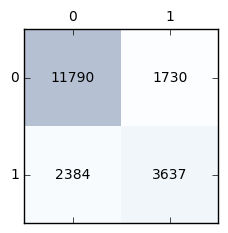

             precision    recall  f1-score   support

        NDF       0.83      0.87      0.85     13520
         US       0.68      0.60      0.64      6021

avg / total       0.78      0.79      0.79     19541



In [16]:
from sklearn.metrics import confusion_matrix, classification_report

mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(2.5,2.5))
ax.matshow(mat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(2):
    for j in range(2):
        ax.text(x=j,y=i,s=mat[i,j], ha='center', va='center')
plt.show()
print(classification_report(y_test, y_pred))

In [17]:
importances = clf.feature_importances_
arg_sort = np.argsort(importances)[::-1]
for i in range(10):
    idx = arg_sort[i]
    print('%2d. %-*s %.2f %%' %(i+1,25, feature_columns[idx],importances[idx]*100))

 1. ageCat                    29.14 %
 2. pending                   13.94 %
 3. message_post              9.71 %
 4. p5                        5.60 %
 5. gender                    3.96 %
 6. create_phone_numbers      3.35 %
 7. post_checkout_action      3.04 %
 8. create_user               2.45 %
 9. at_checkpoint             2.27 %
10. contact_host              1.48 %
